# **Memory-Augmented Autoencoder (MemAE) for Anomaly Detection**

This notebook implements a simple **Memory-Augmented Autoencoder (MemAE)** model using the MNIST dataset for anomaly detection. We train the MemAE model on the MNIST digits (0–9) and test its performance on both normal and noisy (anomalous) data.

### Objectives:
1. Train MemAE on MNIST digits (normal data).
2. Test the model on both normal MNIST digits and noisy images (simulated anomalies).
3. Visualize the reconstructed images for both normal and anomalous data.

In [ ]:
# Import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


## **1. Defining the Model Components**

We define the components of the Memory-Augmented Autoencoder, including the **Encoder**, **Decoder**, and **Memory Module**. These will be combined to form the MemAE model.


In [ ]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size=784, latent_size=128):  # Increased latent size
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Increased hidden layer size
        self.fc2 = nn.Linear(512, latent_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        z = self.fc2(x)
        return z

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_size=128, output_size=784):  # Adjust latent size
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 512)  # Increased hidden layer size
        self.fc2 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        x_hat = self.sigmoid(self.fc2(z))
        return x_hat

# Define the Memory Module
class MemoryModule(nn.Module):
    def __init__(self, memory_size=100, latent_size=128):  # Adjusted latent size
        super(MemoryModule, self).__init__()
        self.memory = nn.Parameter(torch.randn(memory_size, latent_size))  # Learnable memory
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, z):
        # Compute similarity between latent vector and memory
        similarity = self.cosine_similarity(z.unsqueeze(1), self.memory.unsqueeze(0))
        # Get the most relevant memory item
        weight = torch.softmax(similarity, dim=1)
        memory_retrieval = torch.mm(weight, self.memory)
        return memory_retrieval


## **2. Defining the Memory-Augmented Autoencoder (MemAE) Model**

The MemAE consists of an Encoder, Memory Module, and Decoder. The Encoder compresses the input, the Memory Module retrieves a memory item based on similarity, and the Decoder reconstructs the input.


In [ ]:
# Define MemAE model
class MemAE(nn.Module):
    def __init__(self, input_size=784, latent_size=128, memory_size=100):
        super(MemAE, self).__init__()
        self.encoder = Encoder(input_size, latent_size)
        self.memory = MemoryModule(memory_size, latent_size)
        self.decoder = Decoder(latent_size, input_size)

    def forward(self, x):
        z = self.encoder(x)
        z_memory = self.memory(z)
        x_hat = self.decoder(z_memory)
        return x_hat


## **3. Data Preprocessing and Loading**

We load the MNIST dataset and apply basic transformations (normalization). The dataset is split into a training set for model training and a test set for evaluating performance on normal and anomalous data.


In [ ]:
# Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])  # Normalize between [0, 1]
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders (normal data)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  # Normal test set


## **4. Visualization Function**

This function is used to visualize the original and reconstructed images to compare the performance of the MemAE model on both normal and anomalous data.


In [ ]:
# Function to visualize original and reconstructed images
def visualize_reconstruction(original, reconstructed, title="Reconstruction", n=10):
    plt.figure(figsize=(10, 2))
    plt.suptitle(title)
    for i in range(n):
        # Original images
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # Reconstructed images
        plt.subplot(2, n, i+1+n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.show()


## **5. Training the MemAE Model**

We define a training loop to train the MemAE model using Mean Squared Error (MSE) loss. After training, the final batch of images will be returned for visualization.


In [ ]:
# Define training loop
def train(model, train_loader, epochs=10, lr=1e-4):  # Lowered learning rate
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.view(images.size(0), -1)  # Flatten the images
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Display loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}')

    return images, outputs  # Return the final batch of original and reconstructed images after all epochs


## **6. Train and Visualize MemAE on Normal Data**

We initialize the MemAE model and train it for 50 epochs. After training, we visualize the model's performance by comparing the original and reconstructed images on the MNIST test data.


Epoch [1/50], Loss: 0.0823
Epoch [2/50], Loss: 0.0591
Epoch [3/50], Loss: 0.0527
Epoch [4/50], Loss: 0.0485
Epoch [5/50], Loss: 0.0431
Epoch [6/50], Loss: 0.0391
Epoch [7/50], Loss: 0.0379
Epoch [8/50], Loss: 0.0367
Epoch [9/50], Loss: 0.0344
Epoch [10/50], Loss: 0.0326
Epoch [11/50], Loss: 0.0317
Epoch [12/50], Loss: 0.0304
Epoch [13/50], Loss: 0.0295
Epoch [14/50], Loss: 0.0290
Epoch [15/50], Loss: 0.0285
Epoch [16/50], Loss: 0.0277
Epoch [17/50], Loss: 0.0268
Epoch [18/50], Loss: 0.0257
Epoch [19/50], Loss: 0.0249
Epoch [20/50], Loss: 0.0244
Epoch [21/50], Loss: 0.0238
Epoch [22/50], Loss: 0.0232
Epoch [23/50], Loss: 0.0227
Epoch [24/50], Loss: 0.0221
Epoch [25/50], Loss: 0.0215
Epoch [26/50], Loss: 0.0209
Epoch [27/50], Loss: 0.0202
Epoch [28/50], Loss: 0.0196
Epoch [29/50], Loss: 0.0190
Epoch [30/50], Loss: 0.0186
Epoch [31/50], Loss: 0.0182
Epoch [32/50], Loss: 0.0178
Epoch [33/50], Loss: 0.0175
Epoch [34/50], Loss: 0.0172
Epoch [35/50], Loss: 0.0169
Epoch [36/50], Loss: 0.0166
E

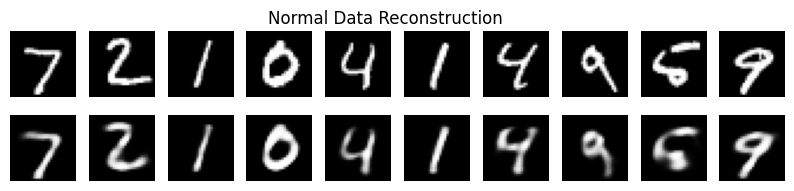

In [ ]:
# Initialize and train MemAE model
model = MemAE()
original_images, reconstructed_images = train(model, train_loader, epochs=50, lr=1e-4)

# Visualize the final reconstructed images for the normal test set
with torch.no_grad():
    test_images, _ = next(iter(test_loader))
    test_images = test_images.view(test_images.size(0), -1)
    reconstructed_test_images = model(test_images)
    visualize_reconstruction(test_images.detach().numpy(), reconstructed_test_images.detach().numpy(), title="Normal Data Reconstruction")


## **7. Testing on Anomalous Data**

To simulate anomalies, we add random noise to the MNIST test images and feed them to the trained MemAE model. We then visualize the original noisy images and their corresponding reconstructions to see how the model handles anomalies.


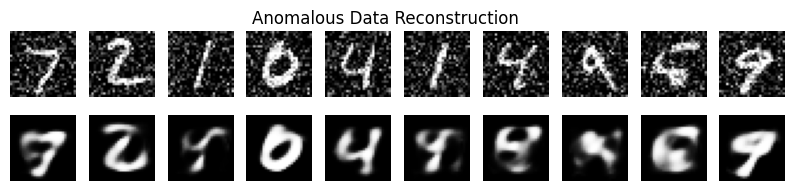

In [ ]:
# Function to add noise to images (simulate anomalous data)
def add_noise(images, noise_factor=0.3):
    """Adds random noise to the images to simulate anomalies."""
    noisy_images = images + noise_factor * torch.randn(*images.shape)
    noisy_images = torch.clip(noisy_images, 0., 1.)  # Clip values between 0 and 1
    return noisy_images

# Test on noisy (anomalous) data
with torch.no_grad():
    for images, _ in test_loader:
        images = images.view(images.size(0), -1)
        noisy_images = add_noise(images)  # Add noise to simulate anomalies
        reconstructed_noisy = model(noisy_images)  # Reconstruct noisy data
        visualize_reconstruction(noisy_images.numpy(), reconstructed_noisy.numpy(), title="Anomalous Data Reconstruction")
        break  # Only visualize one batch of noisy data


# **Conclusion**

In this notebook, we successfully trained a Memory-Augmented Autoencoder (MemAE) on the MNIST dataset to detect anomalies. The model was tested on both normal data (MNIST digits) and anomalous data (noisy images), and the results were visualized to demonstrate the reconstruction quality.
